#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy import interpolate
import scipy

In [2]:
import sys
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../miscellaneous/Ocean_Intella_1/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 50

In [6]:
mi = [mp for i in range(node_N)]

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H= 13
Xg = L/2 # [m]
mn = 27_162_500 #123000000 # mass of the vessel, [kg]

In [8]:
lx,ly,lz=L/2,B/2,H/2

In [9]:
vessel_mass=mn/L # mass over length of the vessel

In [10]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
Irho_=np.diag(diag_Irho)

In [11]:
Irho_

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [12]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [13]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [14]:
vessel_inertia

60751987031.24999

In [15]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [16]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [17]:
math.pi*(d0**4-dI**4)/64

0.005336285849082509

In [18]:
E = 210e9

In [19]:
E*Ar/1e10

1.6991625880187402

In [20]:
diag_DT = 1.5*np.array([1, 1, 1])

In [21]:
DT=np.diag(diag_DT) # (35) in [2]

In [22]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [23]:
diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]

In [24]:
CT=np.diag(diag_CT)

In [25]:
CT

array([[1.e+09, 0.e+00, 0.e+00],
       [0.e+00, 1.e+09, 0.e+00],
       [0.e+00, 0.e+00, 1.e+09]])

In [26]:
# angles should be in radians, otherwise np.radians them
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]

    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])


    return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )

In [27]:
Re_t_([1,2,3])

array([[ 0.51995985, -0.69876354,  0.4912955 ],
       [ 0.07624747, -0.53489523, -0.84147098],
       [ 0.85078086,  0.47499117, -0.2248451 ]])

In [28]:
rng = np.random.default_rng()

In [29]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [30]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [31]:
Re_t_(np.array([φ[1], θ[1], ψ[1]]))

array([[ 0.08153247, -0.13850953, -0.98699927],
       [ 0.56812125,  0.82011736, -0.06815987],
       [ 0.81889603, -0.55517802,  0.1455564 ]])

In [32]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.002000


In [33]:
Ret.shape

(50, 3, 3)

In [34]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [35]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float64)))
    return np.array(ans).T

In [36]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000397


In [37]:
C1(dx,dy,dz,Ret)

array([[ 3.04589177e+00,  7.54615633e-01,  1.96752678e-01,
         6.05946772e-01,  6.12689712e-02, -5.42108191e-02,
        -4.03197822e-01, -2.84159542e-01,  2.28747939e-02,
         1.87254541e+00, -5.06321624e-01,  2.27862316e-01,
        -8.69640380e-01, -1.55675494e-03,  3.65552927e+00,
        -1.43374186e-02, -8.89839179e-02, -2.73903419e-02,
        -6.94147554e-02, -1.02038540e-02, -2.35649536e-01,
        -3.48932955e-02,  3.27649452e-01, -3.85470337e-05,
         2.09130887e+00, -4.52493445e+00,  8.19490999e-02,
        -5.72416712e-01,  2.75534686e+00, -4.80064733e-01,
        -5.99659748e-01, -5.27377400e-01, -1.08843087e+00,
        -4.11103176e-02, -3.42722962e-01,  3.54532088e-01,
        -8.33029571e-03,  4.55506400e+00,  3.12186557e-01,
        -1.08816263e+00, -8.58419255e-01,  3.88415684e-03,
         2.16976948e-01,  2.83931315e-02, -9.42793199e-03,
         4.57606300e-01,  1.07628717e+00,  2.55827433e-04,
        -8.03676823e-02,  3.06733153e-01],
       [-3.10

In [38]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [39]:
fD(dx,dy,dz,DT,Ret).T

array([[ 1.74804763e+04, -1.78365482e+02,  2.02710067e+03],
       [ 4.33076473e+03,  3.95767200e+01,  4.99172096e+01],
       [ 1.12917029e+03,  2.54647129e+03, -3.16290816e+02],
       [ 3.47754909e+03,  1.62069809e+03,  1.29303207e+04],
       [ 3.51624705e+02,  1.87868361e+03, -3.72968350e+03],
       [-3.11117730e+02, -1.42613486e+03,  1.71282419e+03],
       [-2.31396598e+03,  4.09318749e+03, -1.38103511e+03],
       [-1.63080125e+03,  5.83457385e+03, -3.47947484e+03],
       [ 1.31279218e+02, -1.54455695e+04, -2.03757135e+02],
       [ 1.07466017e+04,  2.20952715e+03,  4.48050742e+01],
       [-2.90579698e+03, -4.27437170e+03, -9.12913272e+03],
       [ 1.30770956e+03,  8.47879945e+03, -4.18786790e+03],
       [-4.99089565e+03, -8.66143372e+02,  1.97137633e+03],
       [-8.93426943e+00,  6.89903401e+03,  2.01333039e+04],
       [ 2.09792066e+04, -6.58692497e+03, -2.88691992e+03],
       [-8.22829320e+01, -2.41639123e+03,  4.32360826e+03],
       [-5.10681724e+02, -8.01301147e+03

In [40]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000276


In [41]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html
# 1-D Gray-Scott

In [42]:
I=np.identity(3)

In [43]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000173


In [44]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [45]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [46]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [47]:
DR=np.diag(diag_DR)

In [48]:
Ar

0.08091250419136858

In [49]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [50]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [51]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [52]:
def Re_b(Ret):
    return Ret

In [53]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000025


In [54]:
def phi(x, y, z, Ret,dummy,dummy1): # here
    B=np.vstack([x,y,z])
    return np.linalg.solve(Ret.astype(np.float64),B.T.astype(np.float64))

In [55]:
phi(x,y,z,Ret,None,None)

array([[ 0.14899149,  0.87292897, -0.82768313],
       [ 0.85745886, -2.15043044,  1.27886104],
       [ 0.20942202,  2.29224929, -0.44824639],
       [ 1.17880597,  2.68621595,  0.14381969],
       [-0.2302613 , -0.7252134 ,  0.80202431],
       [ 0.54603082,  0.78425261,  0.32923467],
       [ 0.26035648, -0.78531779, -0.43848249],
       [-1.24107595, -1.43472677,  0.0618736 ],
       [ 1.85044939, -0.75654066, -1.22136324],
       [-0.27008987, -0.43965751,  0.07206768],
       [ 0.57436771, -0.40055482,  0.49812026],
       [-0.27326334, -0.85779901,  0.29372417],
       [-0.74988958,  1.68179826, -0.75006156],
       [-0.02203923, -0.59219564, -0.14232509],
       [-0.02557457, -0.00791464,  0.33295646],
       [ 0.95932855, -0.29029732,  1.63091691],
       [-1.4621173 , -1.08222841, -0.14306333],
       [ 0.85313403, -2.32760337, -2.99393964],
       [ 0.66993087,  0.52241205, -0.16453796],
       [ 0.85401901, -0.35907672, -0.24155288],
       [ 0.16248889, -0.05096885,  0.801

In [56]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.000314


In [57]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [58]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)

    return np.apply_along_axis(Π_, 1, xyz)


In [59]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.000512


In [60]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float64))

In [61]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.000691


In [62]:
ωe(φ,θ,ψ,None,None,None)

array([[-0.8002922 , -1.8535894 ,  0.98583927],
       [-0.58800301, -1.46567141,  0.15566549],
       [-1.19389002, -1.95070478,  0.17845681],
       [-1.50839066,  0.99184116,  0.27356475],
       [-0.47846609,  0.80418512, -1.1481685 ],
       [ 1.09888638,  0.23517221, -0.79181122],
       [-1.43241778, -0.81957846,  0.75538845],
       [ 0.45603057, -1.82836145, -1.36920356],
       [ 1.18823277,  1.27495339, -0.97773626],
       [ 0.48231836,  0.60836248, -2.13104098],
       [ 0.32248561, -0.24517027,  0.05984964],
       [-0.66643214, -0.16633152, -0.18474927],
       [ 0.69988563, -0.70679148,  0.66930129],
       [ 0.3990946 , -0.5078811 , -0.35481035],
       [-0.65475748, -0.53907705, -0.46242865],
       [ 0.04194649,  1.73140319, -0.68696303],
       [ 0.40638335,  1.45941793, -1.03408718],
       [ 0.68663993, -0.89812769,  0.72976858],
       [ 0.35622619,  2.07241326, -1.2540789 ],
       [-0.32959053,  0.63017276,  1.62637585],
       [ 0.21308352,  0.48849947, -0.520

In [63]:
def d_s(f,a,b,c,Ret,omega): # here

    fun = f(a,b,c,Ret,omega, None)

    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)



    return np.einsum('ijk,ik->ij',K, fun).T

In [64]:
φ, θ, ψ = np.array([0.1 for i in range(node_N)]),np.array([0.01 for i in range(node_N)]),np.array([0.01 for i in range(node_N)])

In [65]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None))

array([[-1.52628578e-02,  3.07572877e-02, -2.45495886e-02,
        -2.27458363e-02,  1.37098963e-02, -4.05505596e-03,
         3.08117644e-03,  1.33971399e-02, -4.22359710e-03,
         4.58347078e-03,  8.06870188e-03,  1.03209312e-02,
        -2.18031593e-02,  4.01872806e-03,  3.06799536e-03,
         1.72790025e-02,  8.39766069e-03, -6.11941623e-03,
        -6.15647416e-03,  1.03920068e-03,  7.66868521e-03,
        -1.47919229e-02, -6.52121757e-03,  1.33122596e-02,
         2.71578413e-02, -2.10906367e-02,  1.11743851e-02,
         6.17089569e-03,  1.08424881e-02, -1.87999763e-03,
         1.46522980e-02, -1.96122785e-03, -1.46820726e-02,
        -1.92864137e-02, -1.53078390e-02, -2.91071123e-04,
         1.60220239e-02,  1.45287139e-02, -1.35409260e-02,
         2.44130309e-02,  1.11601465e-02, -1.58839044e-02,
        -5.85725240e-03, -5.49671621e-03,  1.76337054e-02,
        -1.42866924e-02, -2.46994892e-02,  1.01368550e-03,
         6.63795516e-03, -7.88885717e-03],
       [ 8.41

In [66]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.001125


In [67]:
def ne(x,y,z,Ret,omega,force): # here
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float64),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [68]:
φ, θ, ψ = np.array([0.01 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [69]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))

array([[-1.63355339e-06, -8.58801542e-07, -2.91627007e-06,
         2.64280114e-06,  8.98238195e-07,  1.51175042e-06,
         6.00586517e-07, -8.63321852e-07,  3.58397142e-07,
        -2.50393282e-07,  1.34755538e-06,  4.82474551e-07,
        -1.55667879e-06,  1.54129289e-07, -1.61267995e-08,
        -3.50866822e-08, -7.43484378e-07, -4.89438339e-06,
        -6.57348789e-07, -1.38831730e-06,  1.27471242e-06,
         8.05438514e-07, -1.22129186e-06,  1.38589234e-06,
         4.32193846e-06, -1.77481102e-06,  1.65375091e-06,
         6.51324147e-07,  1.49255542e-06, -5.23140407e-08,
         1.69073446e-06, -5.50657469e-08, -3.04203334e-06,
        -6.16122786e-07, -1.68741237e-06, -6.62238000e-07,
        -2.13191219e-06,  9.63749432e-07, -1.17464218e-06,
        -5.30267029e-07,  1.15648818e-06, -4.91594676e-06,
        -5.88083886e-07,  6.16408945e-07, -1.54694616e-06,
        -1.34242724e-06, -2.89984692e-06,  4.93569479e-08,
        -6.85553699e-07, -8.71115854e-07],
       [ 7.97

In [70]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [71]:
ne_(dx,dy,dz,DT,Ret)

array([[-1.74804763e+04, -4.33076473e+03, -1.12917029e+03,
        -3.47754909e+03, -3.51624705e+02,  3.11117730e+02,
         2.31396598e+03,  1.63080125e+03, -1.31279218e+02,
        -1.07466017e+04,  2.90579698e+03, -1.30770956e+03,
         4.99089565e+03,  8.93426943e+00, -2.09792066e+04,
         8.22829320e+01,  5.10681724e+02,  1.57194102e+02,
         3.98373637e+02,  5.85602644e+01,  1.35240069e+03,
         2.00253807e+02, -1.88039133e+03,  2.21222734e-01,
        -1.20020926e+04,  2.59687524e+04, -4.70308666e+02,
         3.28511894e+03, -1.58130291e+04,  2.75510780e+03,
         3.44146764e+03,  3.02663680e+03,  6.24654168e+03,
         2.35933508e+02,  1.96689871e+03, -2.03467169e+03,
         4.78078498e+01, -2.61416669e+04, -1.79164925e+03,
         6.24500227e+03,  4.92649724e+03, -2.22913079e+01,
        -1.24523807e+03, -1.62949145e+02,  5.41072217e+01,
        -2.62621809e+03, -6.17684859e+03, -1.46820232e+00,
         4.61232856e+02, -1.76035197e+03],
       [ 1.78

In [72]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.000962


In [73]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None)).T

array([[-2.21483515e+01,  5.17422750e+05, -2.93716950e+05],
       [ 3.69161096e+02,  1.78052461e+05, -3.90714978e+06],
       [ 9.75458524e+01,  1.30234829e+04, -9.98385548e+05],
       [ 1.23073590e+00, -1.23987630e+04, -3.29123536e+01],
       [ 1.32133988e+02, -2.20243500e+06,  8.67792455e+05],
       [ 2.05516622e+02, -2.16085637e+06,  8.49355476e+04],
       [-1.32992250e+00,  1.32022762e+04,  2.31293837e+02],
       [-1.17072935e+02,  1.16394624e+06,  1.86094099e+04],
       [ 2.49044788e+02, -2.90581889e+06,  3.90235177e+05],
       [-3.97672386e+01, -2.28794969e+05,  6.30516130e+05],
       [-2.21018893e+02,  2.07247787e+06,  1.60043937e+05],
       [-1.93689855e+02,  1.05523952e+06,  9.01269001e+05],
       [-1.31149693e+02,  3.02146627e+05,  1.02264934e+06],
       [-6.48719491e+02,  2.90636960e+06,  3.64653622e+06],
       [-3.44750942e+02,  2.38444403e+06,  1.09794377e+06],
       [ 2.48862568e+02, -8.00705983e+05, -1.71314371e+06],
       [ 3.24358884e+01, -7.42721187e+05

In [74]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[1,23,4])

array([[ 5.34337984e+07, -2.93664050e+07, -5.17369854e+07],
       [-5.41968101e+05, -3.90715031e+08, -1.78052997e+07],
       [ 1.82041534e+07, -9.98367526e+07, -1.30054617e+06],
       [-1.63423482e+08, -1.94701628e+04,  1.22369819e+06],
       [-4.60630652e+06,  8.67787895e+07,  2.20243044e+08],
       [-4.80985278e+07,  8.48879301e+06,  2.16080876e+08],
       [-3.15845331e+08, -8.13930940e+03, -1.35149473e+06],
       [ 1.20572943e+08,  1.87287772e+06, -1.16382687e+08],
       [ 8.66927234e+06,  3.90243759e+07,  2.90582748e+08],
       [-4.81407073e+08,  6.30039537e+07,  2.28318400e+07],
       [-9.12236179e+08,  1.59140823e+07, -2.07338093e+08],
       [-9.23687852e+08,  9.00354550e+07, -1.05615392e+08],
       [-3.72062584e+08,  1.02228100e+08, -3.02514950e+07],
       [-4.44968468e+08,  3.64609570e+08, -2.90681009e+08],
       [-5.73517245e+08,  1.09737599e+08, -2.38501178e+08],
       [ 3.24551407e+06, -1.71314050e+08,  8.00709196e+07],
       [-8.46000304e+05,  4.15106203e+07

In [75]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000128


In [76]:
Re_b(Ret).shape

(50, 3, 3)

In [77]:
def Irho_e(Ret,Irho): # here
    ans=  np.einsum('ijk,ikp->ijp', np.einsum('ijk,ikp->ijp', Ret,Irho),Ret)
    return ans

In [78]:
diag_CR = 1e11*np.array([1, 1, 1])
CR=np.diag(diag_CR)

In [79]:
CR

array([[1.e+11, 0.e+00, 0.e+00],
       [0.e+00, 1.e+11, 0.e+00],
       [0.e+00, 0.e+00, 1.e+11]])

In [80]:
def d_me(φ,θ,ψ,Ret,omega):

    def f(a,b,c,Ret,omega, dummy2):
        return np.einsum('ijk,ik->ik', np.multiply(np.multiply(Ret,CR),Ret),omega.astype(np.float64)).squeeze()

    B=d_s(f,φ,θ,ψ,Ret.astype(np.float64),omega.astype(np.float64))

    return B.T.astype(np.float64)

In [81]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.001060


In [82]:
d_me_

array([[ 8.80705391e-03,  1.59139401e+01, -1.04879380e+02],
       [-6.38410697e-02, -1.43930048e+01,  6.59285594e+02],
       [-1.04133617e-02,  6.42703400e+01,  4.09171873e+01],
       [ 7.45275547e-05,  2.94504193e+02, -2.95271958e+02],
       [ 5.87182433e-02, -6.58785975e+02,  6.56758337e+01],
       [ 5.21155054e-02, -4.05468375e+02, -1.20956912e+02],
       [ 1.59812311e-04,  4.57312573e+02, -4.58950095e+02],
       [ 2.83006686e-02, -4.66375106e+01, -2.39239904e+02],
       [ 2.98816133e-02, -3.25628575e+02,  2.37953531e+01],
       [-1.35324207e-02,  5.63899342e+02, -4.27229895e+02],
       [-5.45078926e-03,  9.90246788e+01, -4.39684388e+01],
       [ 2.29896006e-03,  3.34997925e+02, -3.58237893e+02],
       [-2.04532274e-02,  4.58950047e+02, -2.52364613e+02],
       [-5.10391014e-03, -1.02153572e+02,  1.53716000e+02],
       [ 1.00241047e-03,  2.13388193e+02, -2.23524876e+02],
       [-4.83745170e-02, -6.21237529e+01,  5.50783065e+02],
       [-7.66302106e-03, -6.86152406e+01

In [83]:
ne_(dx,dy,dz,DT,Ret)

array([[-1.74804763e+04, -4.33076473e+03, -1.12917029e+03,
        -3.47754909e+03, -3.51624705e+02,  3.11117730e+02,
         2.31396598e+03,  1.63080125e+03, -1.31279218e+02,
        -1.07466017e+04,  2.90579698e+03, -1.30770956e+03,
         4.99089565e+03,  8.93426943e+00, -2.09792066e+04,
         8.22829320e+01,  5.10681724e+02,  1.57194102e+02,
         3.98373637e+02,  5.85602644e+01,  1.35240069e+03,
         2.00253807e+02, -1.88039133e+03,  2.21222734e-01,
        -1.20020926e+04,  2.59687524e+04, -4.70308666e+02,
         3.28511894e+03, -1.58130291e+04,  2.75510780e+03,
         3.44146764e+03,  3.02663680e+03,  6.24654168e+03,
         2.35933508e+02,  1.96689871e+03, -2.03467169e+03,
         4.78078498e+01, -2.61416669e+04, -1.79164925e+03,
         6.24500227e+03,  4.92649724e+03, -2.22913079e+01,
        -1.24523807e+03, -1.62949145e+02,  5.41072217e+01,
        -2.62621809e+03, -6.17684859e+03, -1.46820232e+00,
         4.61232856e+02, -1.76035197e+03],
       [ 1.78

### Static solution

In [84]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [85]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [86]:
Fx_0=82945396

In [87]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=30

In [88]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [89]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76])

In [90]:
delta_x=horizontal_length/(node_N-1)

In [91]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [92]:
M_totl=[]
v_mass=vessel_mass*9.81
for i in range(node_N):
    v_mass+=Ws[i]
    M_totl.append(v_mass)
M_totl=np.array(M_totl[::-1])

In [93]:
M_totl

array([3196782.14893616, 3195840.38893616, 3194898.62893616,
       3193956.86893616, 3193015.10893616, 3192073.34893616,
       3191131.58893616, 3190189.82893616, 3189248.06893616,
       3188306.30893616, 3187364.54893616, 3186422.78893616,
       3185481.02893616, 3184539.26893616, 3183597.50893616,
       3182655.74893616, 3181713.98893616, 3180772.22893616,
       3179830.46893616, 3178888.70893616, 3177946.94893616,
       3177005.18893616, 3176063.42893616, 3175121.66893616,
       3174179.90893616, 3173238.14893617, 3172296.38893617,
       3171354.62893617, 3170412.86893617, 3169471.10893617,
       3168529.34893617, 3167587.58893617, 3166645.82893617,
       3165704.06893617, 3164762.30893617, 3163820.54893617,
       3162878.78893617, 3161937.02893617, 3160995.26893617,
       3160053.50893617, 3159111.74893617, 3158169.98893617,
       3157228.22893617, 3156286.46893617, 3155344.70893617,
       3154402.94893617, 3153461.18893617, 3152519.42893617,
       3151577.66893617,

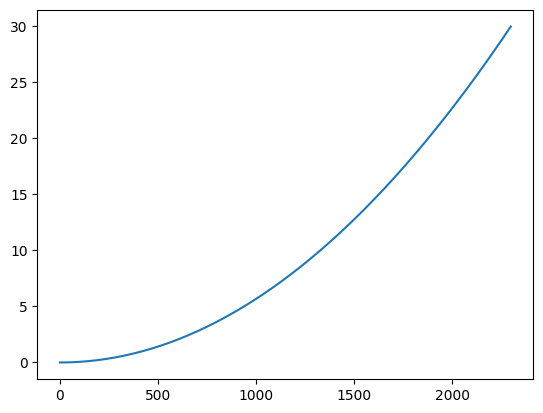

In [94]:
plt.plot(x0, z0)
plt.show()

In [95]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [96]:
init=1
for j in range(1,12):
    if j==1:
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:
        q0[(j-1)*node_N:j*node_N]=z0

In [97]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

    return np.array(ans[::-1])

In [98]:
V_rho=np.zeros(Irho_.shape)
np.fill_diagonal(V_rho, vessel_inertia)

In [99]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)

In [100]:
def static_func(Q): # It is not working properly for non zero roll, pitch and yaw; serves our needs though
    t=0

    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)


    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]

    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]

    tau_force=np.array([-Fx_0,0,0,0,0,0])

    Z0= - np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T

    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T


    Z =  Z1 + Z2 + Z0


############################################################

    ddx,ddy, ddz = np.linalg.solve(Ws[0]*Re_b(Ret),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################



    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1))

    C3=d_me(φ,θ,ψ,Ret,  ωe(φ,θ,ψ,None,None,None))

    B_ =C3
    B=(B_ + C0.squeeze())

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ans_φ=[]
    ans_θ=[]
    ans_ψ=[]
    for i in range(len(A)):
        a,b,c=scipy.linalg.lstsq(A[i],B[i], check_finite=True)[0]
        ans_φ.append(a)
        ans_θ.append(b)
        ans_ψ.append(c)

    ddφ,ddθ,ddψ=np.array(ans_φ),np.array(ans_θ),np.array(ans_ψ)
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)


    return ans

In [101]:
q0

array([0.00000000e+00, 4.69050129e+01, 9.38100257e+01, 1.40715039e+02,
       1.87620051e+02, 2.34525064e+02, 2.81430077e+02, 3.28335090e+02,
       3.75240103e+02, 4.22145116e+02, 4.69050129e+02, 5.15955142e+02,
       5.62860154e+02, 6.09765167e+02, 6.56670180e+02, 7.03575193e+02,
       7.50480206e+02, 7.97385219e+02, 8.44290232e+02, 8.91195244e+02,
       9.38100257e+02, 9.85005270e+02, 1.03191028e+03, 1.07881530e+03,
       1.12572031e+03, 1.17262532e+03, 1.21953033e+03, 1.26643535e+03,
       1.31334036e+03, 1.36024537e+03, 1.40715039e+03, 1.45405540e+03,
       1.50096041e+03, 1.54786542e+03, 1.59477044e+03, 1.64167545e+03,
       1.68858046e+03, 1.73548548e+03, 1.78239049e+03, 1.82929550e+03,
       1.87620051e+03, 1.92310553e+03, 1.97001054e+03, 2.01691555e+03,
       2.06382057e+03, 2.11072558e+03, 2.15763059e+03, 2.20453560e+03,
       2.25144062e+03, 2.29834563e+03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [102]:
root = fsolve(static_func, q0)

/var/folders/6q/zp3bjthx3zv4n0bl2l835qdw0000gn/T/ipykernel_22966/701681181.py:1: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  root = fsolve(static_func, q0)


In [103]:
root

array([0.00000000e+00, 4.69050129e+01, 9.38100257e+01, 1.40715039e+02,
       1.87620051e+02, 2.34525064e+02, 2.81430077e+02, 3.28335090e+02,
       3.75240103e+02, 4.22145116e+02, 4.69050129e+02, 5.15955142e+02,
       5.62860154e+02, 6.09765167e+02, 6.56670180e+02, 7.03575193e+02,
       7.50480206e+02, 7.97385219e+02, 8.44290232e+02, 8.91195244e+02,
       9.38100257e+02, 9.85005270e+02, 1.03191028e+03, 1.07881530e+03,
       1.12572031e+03, 1.17262532e+03, 1.21953033e+03, 1.26643535e+03,
       1.31334036e+03, 1.36024537e+03, 1.40715039e+03, 1.45405540e+03,
       1.50096041e+03, 1.54786542e+03, 1.59477044e+03, 1.64167545e+03,
       1.68858046e+03, 1.73548548e+03, 1.78239049e+03, 1.82929550e+03,
       1.87620051e+03, 1.92310553e+03, 1.97001054e+03, 2.01691555e+03,
       2.06382057e+03, 2.11072558e+03, 2.15763059e+03, 2.20453560e+03,
       2.25144062e+03, 2.29834563e+03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [104]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [105]:
q0=root

In [106]:
q0

array([0.00000000e+00, 4.69050129e+01, 9.38100257e+01, 1.40715039e+02,
       1.87620051e+02, 2.34525064e+02, 2.81430077e+02, 3.28335090e+02,
       3.75240103e+02, 4.22145116e+02, 4.69050129e+02, 5.15955142e+02,
       5.62860154e+02, 6.09765167e+02, 6.56670180e+02, 7.03575193e+02,
       7.50480206e+02, 7.97385219e+02, 8.44290232e+02, 8.91195244e+02,
       9.38100257e+02, 9.85005270e+02, 1.03191028e+03, 1.07881530e+03,
       1.12572031e+03, 1.17262532e+03, 1.21953033e+03, 1.26643535e+03,
       1.31334036e+03, 1.36024537e+03, 1.40715039e+03, 1.45405540e+03,
       1.50096041e+03, 1.54786542e+03, 1.59477044e+03, 1.64167545e+03,
       1.68858046e+03, 1.73548548e+03, 1.78239049e+03, 1.82929550e+03,
       1.87620051e+03, 1.92310553e+03, 1.97001054e+03, 2.01691555e+03,
       2.06382057e+03, 2.11072558e+03, 2.15763059e+03, 2.20453560e+03,
       2.25144062e+03, 2.29834563e+03, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

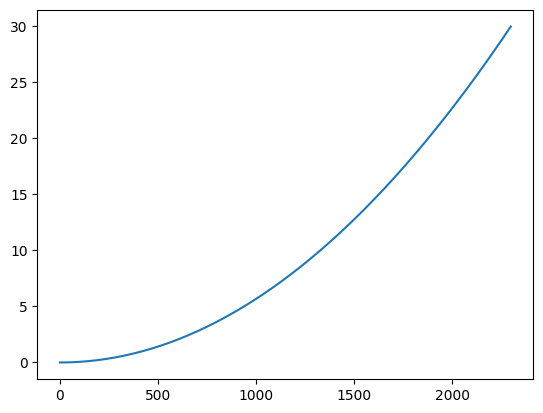

In [107]:
plt.plot(x0_, z0_)
plt.show()

### Finite Element Model of the Space Frame Element

In [108]:
def PlaneTrussElementLength(x1,y1,z1,x2,y2,z2):
    return math.sqrt((x2-x1)*(x2-x1) + (y2-y1)*(y2-y1)+(z2-z1)*(z2-z1))

In [109]:
def SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,x1,y1,z1,x2,y2,z2):
    L = PlaneTrussElementLength(x1,y1,z1,x2,y2,z2)
    w1 = E*A/L
    w2 = 12*E*Iz/(L*L*L)
    w3 = 6*E*Iz/(L*L)
    w4 = 4*E*Iz/L
    w5 = 2*E*Iz/L
    w6 = 12*E*Iy/(L*L*L)
    w7 = 6*E*Iy/(L*L)
    w8 = 4*E*Iy/L
    w9 = 2*E*Iy/L
    w10 = G*J/L

    kprime = np.array([[w1, 0, 0, 0, 0, 0, -w1, 0, 0, 0, 0, 0],
                        [0, w2, 0, 0, 0, w3, 0, -w2, 0, 0, 0, w3],
                        [0, 0, w6, 0, -w7, 0, 0, 0, -w6, 0, -w7, 0],
                        [0, 0, 0, w10, 0, 0, 0, 0, 0, -w10, 0, 0],
                        [0, 0, -w7, 0, w8, 0, 0, 0, w7, 0, w9, 0],
                        [0, w3, 0, 0, 0, w4, 0, -w3, 0, 0, 0, w5],
                        [-w1, 0, 0, 0, 0, 0, w1, 0, 0, 0, 0, 0],
                        [0, -w2, 0, 0, 0, -w3, 0, w2, 0, 0, 0, -w3],
                        [0, 0, -w6, 0, w7, 0, 0, 0, w6, 0, w7, 0],
                        [0, 0, 0, -w10, 0, 0, 0, 0, 0, w10, 0, 0],
                        [0, 0, -w7, 0, w9, 0, 0, 0, w7, 0, w8, 0],
                        [0, w3, 0, 0, 0, w5, 0, -w3, 0, 0, 0, w4]])


    if x1 == x2 and y1 == y2:
        if z2 > z1:
            Lambda = np.array([[0, 0, 1], [0, 1, 0], [-1, 0, 0]])
        else:
            Lambda = np.array([[0, 0, -1], [0, 1, 0], [1, 0, 0]])
    else:
        CXx = (x2-x1)/L
        CYx = (y2-y1)/L
        CZx = (z2-z1)/L
        D = math.sqrt(CXx*CXx + CYx*CYx)
        CXy = -CYx/D
        CYy = CXx/D
        CZy = 0
        CXz = -CXx*CZx/D
        CYz = -CYx*CZx/D
        CZz = D
        Lambda = np.array([[CXx, CYx, CZx], [CXy, CYy, CZy], [CXz, CYz, CZz]])


    R = np.array([np.concatenate((np.concatenate((Lambda,np.zeros((3,3)),np.zeros((3,3)),np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), Lambda, np.zeros((3,3)), np.zeros((3,3))),axis=1) ,
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), Lambda, np.zeros((3,3))),axis=1),
        np.concatenate((np.zeros((3,3)), np.zeros((3,3)), np.zeros((3,3)), Lambda),axis=1)))])[0]
    return np.dot(np.dot(R.T,kprime),R)

In [110]:
def SpaceFrameAssemble(K,k,i,j):
    K[6*i,6*i] = K[6*i,6*i] + k[0,0]
    K[6*i,6*i+1] = K[6*i,6*i+1] + k[0,1]
    K[6*i,6*i+2] = K[6*i,6*i+2] + k[0,2]
    K[6*i,6*i+3] = K[6*i,6*i+3] + k[0,3]
    K[6*i,6*i+4] = K[6*i,6*i+4] + k[0,4]
    K[6*i,6*i+5] = K[6*i,6*i+5] + k[0,5]
    K[6*i,6*j] = K[6*i,6*j] + k[0,6]
    K[6*i,6*j+1] = K[6*i,6*j+1] + k[0,7]
    K[6*i,6*j+2] = K[6*i,6*j+2] + k[0,8]
    K[6*i,6*j+3] = K[6*i,6*j+3] + k[0,9]
    K[6*i,6*j+4] = K[6*i,6*j+4] + k[0,10]
    K[6*i,6*j+5] = K[6*i,6*j+5] + k[0,11]
    K[6*i+1,6*i] = K[6*i+1,6*i] + k[1,0]
    K[6*i+1,6*i+1] = K[6*i+1,6*i+1] + k[1,1]
    K[6*i+1,6*i+2] = K[6*i+1,6*i+2] + k[1,2]
    K[6*i+1,6*i+3] = K[6*i+1,6*i+3] + k[1,3]
    K[6*i+1,6*i+4] = K[6*i+1,6*i+4] + k[1,4]
    K[6*i+1,6*i+5] = K[6*i+1,6*i+5] + k[1,5]
    K[6*i+1,6*j] = K[6*i+1,6*j] + k[1,6]
    K[6*i+1,6*j+1] = K[6*i+1,6*j+1] + k[1,7]
    K[6*i+1,6*j+2] = K[6*i+1,6*j+2] + k[1,8]
    K[6*i+1,6*j+3] = K[6*i+1,6*j+3] + k[1,9]
    K[6*i+1,6*j+4] = K[6*i+1,6*j+4] + k[1,10]
    K[6*i+1,6*j+5] = K[6*i+1,6*j+5] + k[1,11]
    K[6*i+2,6*i]   = K[6*i+2,6*i] + k[2,0]
    K[6*i+2,6*i+1] = K[6*i+2,6*i+1] + k[2,1]
    K[6*i+2,6*i+2] = K[6*i+2,6*i+2] + k[2,2]
    K[6*i+2,6*i+3] = K[6*i+2,6*i+3] + k[2,3]
    K[6*i+2,6*i+4] = K[6*i+2,6*i+4] + k[2,4]
    K[6*i+2,6*i+5] = K[6*i+2,6*i+5] + k[2,5]
    K[6*i+2,6*j]   = K[6*i+2,6*j] + k[2,6]
    K[6*i+2,6*j+1] = K[6*i+2,6*j+1] + k[2,7]
    K[6*i+2,6*j+2] = K[6*i+2,6*j+2] + k[2,8]
    K[6*i+2,6*j+3] = K[6*i+2,6*j+3] + k[2,9]
    K[6*i+2,6*j+4] = K[6*i+2,6*j+4] + k[2,10]
    K[6*i+2,6*j+5] = K[6*i+2,6*j+5] + k[2,11]
    K[6*i+3,6*i] = K[6*i+3,6*i] + k[3,0]
    K[6*i+3,6*i+1] = K[6*i+3,6*i+1] + k[3,1]
    K[6*i+3,6*i+2] = K[6*i+3,6*i+2] + k[3,2]
    K[6*i+3,6*i+3] = K[6*i+3,6*i+3] + k[3,3]
    K[6*i+3,6*i+4] = K[6*i+3,6*i+4] + k[3,4]
    K[6*i+3,6*i+5] = K[6*i+3,6*i+5] + k[3,5]
    K[6*i+3,6*j] = K[6*i+3,6*j] + k[3,6]
    K[6*i+3,6*j+1] = K[6*i+3,6*j+1] + k[3,7]
    K[6*i+3,6*j+2] = K[6*i+3,6*j+2] + k[3,8]
    K[6*i+3,6*j+3] = K[6*i+3,6*j+3] + k[3,9]
    K[6*i+3,6*j+4] = K[6*i+3,6*j+4] + k[3,10]
    K[6*i+3,6*j+5] = K[6*i+3,6*j+5] + k[3,11]
    K[6*i+4,6*i] = K[6*i+4,6*i] + k[4,0]
    K[6*i+4,6*i+1] = K[6*i+4,6*i+1] + k[4,1]
    K[6*i+4,6*i+2] = K[6*i+4,6*i+2] + k[4,2]
    K[6*i+4,6*i+3] = K[6*i+4,6*i+3] + k[4,3]
    K[6*i+4,6*i+4] = K[6*i+4,6*i+4] + k[4,4]
    K[6*i+4,6*i+5] = K[6*i+4,6*i+5] + k[4,5]
    K[6*i+4,6*j] = K[6*i+4,6*j] + k[4,6]
    K[6*i+4,6*j+1] = K[6*i+4,6*j+1] + k[4,7]
    K[6*i+4,6*j+2] = K[6*i+4,6*j+2] + k[4,8]
    K[6*i+4,6*j+3] = K[6*i+4,6*j+3] + k[4,9]
    K[6*i+4,6*j+4] = K[6*i+4,6*j+4] + k[4,10]
    K[6*i+4,6*j+5] = K[6*i+4,6*j+5] + k[4,11]
    K[6*i+5,6*i] = K[6*i+5,6*i] + k[5,0]
    K[6*i+5,6*i+1] = K[6*i+5,6*i+1] + k[5,1]
    K[6*i+5,6*i+2] = K[6*i+5,6*i+2] + k[5,2]
    K[6*i+5,6*i+3] = K[6*i+5,6*i+3] + k[5,3]
    K[6*i+5,6*i+4] = K[6*i+5,6*i+4] + k[5,4]
    K[6*i+5,6*i+5] = K[6*i+5,6*i+5] + k[5,5]
    K[6*i+5,6*j] = K[6*i+5,6*j] + k[5,6]
    K[6*i+5,6*j+1] = K[6*i+5,6*j+1] + k[5,7]
    K[6*i+5,6*j+2] = K[6*i+5,6*j+2] + k[5,8]
    K[6*i+5,6*j+3] = K[6*i+5,6*j+3] + k[5,9]
    K[6*i+5,6*j+4] = K[6*i+5,6*j+4] + k[5,10]
    K[6*i+5,6*j+5] = K[6*i+5,6*j+5] + k[5,11]
    K[6*j,6*i] = K[6*j,6*i] + k[6,0]
    K[6*j,6*i+1] = K[6*j,6*i+1] + k[6,1]
    K[6*j,6*i+2] = K[6*j,6*i+2] + k[6,2]
    K[6*j,6*i+3] = K[6*j,6*i+3] + k[6,3]
    K[6*j,6*i+4] = K[6*j,6*i+4] + k[6,4]
    K[6*j,6*i+5] = K[6*j,6*i+5] + k[6,5]
    K[6*j,6*j] = K[6*j,6*j] + k[6,6]
    K[6*j,6*j+1] = K[6*j,6*j+1] + k[6,7]
    K[6*j,6*j+2] = K[6*j,6*j+2] + k[6,8]
    K[6*j,6*j+3] = K[6*j,6*j+3] + k[6,9]
    K[6*j,6*j+4] = K[6*j,6*j+4] + k[6,10]
    K[6*j,6*j+5] = K[6*j,6*j+5] + k[6,11]
    K[6*j+1,6*i] = K[6*j+1,6*i] + k[7,0]
    K[6*j+1,6*i+1] = K[6*j+1,6*i+1] + k[7,1]
    K[6*j+1,6*i+2] = K[6*j+1,6*i+2] + k[7,2]
    K[6*j+1,6*i+3] = K[6*j+1,6*i+3] + k[7,3]
    K[6*j+1,6*i+4] = K[6*j+1,6*i+4] + k[7,4]
    K[6*j+1,6*i+5] = K[6*j+1,6*i+5] + k[7,5]
    K[6*j+1,6*j] = K[6*j+1,6*j] + k[7,6]
    K[6*j+1,6*j+1] = K[6*j+1,6*j+1] + k[7,7]
    K[6*j+1,6*j+2] = K[6*j+1,6*j+2] + k[7,8]
    K[6*j+1,6*j+3] = K[6*j+1,6*j+3] + k[7,9]
    K[6*j+1,6*j+4] = K[6*j+1,6*j+4] + k[7,10]
    K[6*j+1,6*j+5] = K[6*j+1,6*j+5] + k[7,11]
    K[6*j+2,6*i] = K[6*j+2,6*i] + k[8,0]
    K[6*j+2,6*i+1] = K[6*j+2,6*i+1] + k[8,1]
    K[6*j+2,6*i+2] = K[6*j+2,6*i+2] + k[8,2]
    K[6*j+2,6*i+3] = K[6*j+2,6*i+3] + k[8,3]
    K[6*j+2,6*i+4] = K[6*j+2,6*i+4] + k[8,4]
    K[6*j+2,6*i+5] = K[6*j+2,6*i+5] + k[8,5]
    K[6*j+2,6*j] = K[6*j+2,6*j] + k[8,6]
    K[6*j+2,6*j+1] = K[6*j+2,6*j+1] + k[8,7]
    K[6*j+2,6*j+2] = K[6*j+2,6*j+2] + k[8,8]
    K[6*j+2,6*j+3] = K[6*j+2,6*j+3] + k[8,9]
    K[6*j+2,6*j+4] = K[6*j+2,6*j+4] + k[8,10]
    K[6*j+2,6*j+5] = K[6*j+2,6*j+5] + k[8,11]
    K[6*j+3,6*i] = K[6*j+3,6*i] + k[9,0]
    K[6*j+3,6*i+1] = K[6*j+3,6*i+1] + k[9,1]
    K[6*j+3,6*i+2] = K[6*j+3,6*i+2] + k[9,2]
    K[6*j+3,6*i+3] = K[6*j+3,6*i+3] + k[9,3]
    K[6*j+3,6*i+4] = K[6*j+3,6*i+4] + k[9,4]
    K[6*j+3,6*i+5] = K[6*j+3,6*i+5] + k[9,5]
    K[6*j+3,6*j] = K[6*j+3,6*j] + k[9,6]
    K[6*j+3,6*j+1] = K[6*j+3,6*j+1] + k[9,7]
    K[6*j+3,6*j+2] = K[6*j+3,6*j+2] + k[9,8]
    K[6*j+3,6*j+3] = K[6*j+3,6*j+3] + k[9,9]
    K[6*j+3,6*j+4] = K[6*j+3,6*j+4] + k[9,10]
    K[6*j+3,6*j+5] = K[6*j+3,6*j+5] + k[9,11]
    K[6*j+4,6*i] = K[6*j+4,6*i] + k[10,0]
    K[6*j+4,6*i+1] = K[6*j+4,6*i+1] + k[10,1]
    K[6*j+4,6*i+2] = K[6*j+4,6*i+2] + k[10,2]
    K[6*j+4,6*i+3] = K[6*j+4,6*i+3] + k[10,3]
    K[6*j+4,6*i+4] = K[6*j+4,6*i+4] + k[10,4]
    K[6*j+4,6*i+5] = K[6*j+4,6*i+5] + k[10,5]
    K[6*j+4,6*j] = K[6*j+4,6*j] + k[10,6]
    K[6*j+4,6*j+1] = K[6*j+4,6*j+1] + k[10,7]
    K[6*j+4,6*j+2] = K[6*j+4,6*j+2] + k[10,8]
    K[6*j+4,6*j+3] = K[6*j+4,6*j+3] + k[10,9]
    K[6*j+4,6*j+4] = K[6*j+4,6*j+4] + k[10,10]
    K[6*j+4,6*j+5] = K[6*j+4,6*j+5] + k[10,11]
    K[6*j+5,6*i] = K[6*j+5,6*i] + k[11,0]
    K[6*j+5,6*i+1] = K[6*j+5,6*i+1] + k[11,1]
    K[6*j+5,6*i+2] = K[6*j+5,6*i+2] + k[11,2]
    K[6*j+5,6*i+3] = K[6*j+5,6*i+3] + k[11,3]
    K[6*j+5,6*i+4] = K[6*j+5,6*i+4] + k[11,4]
    K[6*j+5,6*i+5] = K[6*j+5,6*i+5] + k[11,5]
    K[6*j+5,6*j] = K[6*j+5,6*j] + k[11,6]
    K[6*j+5,6*j+1] = K[6*j+5,6*j+1] + k[11,7]
    K[6*j+5,6*j+2] = K[6*j+5,6*j+2] + k[11,8]
    K[6*j+5,6*j+3] = K[6*j+5,6*j+3] + k[11,9]
    K[6*j+5,6*j+4] = K[6*j+5,6*j+4] + k[11,10]
    K[6*j+5,6*j+5] = K[6*j+5,6*j+5] + k[11,11]

    return K

In [111]:
def FEA_u(coord, elcon, bc_node, bc_val, vessel_movement, coefs,
          E=210e9, G=84e9, A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5):


    coord=np.array(coord)
    elcon=np.array(elcon)

    K=np.zeros(shape=(6*(np.max(elcon)+1),6*(np.max(elcon)+1)))
    for el in elcon:
        k=SpaceFrameElementStiffness(E,G,A,Iy,Iz,J,
                                     coord[el[0]][0],coord[el[0]][1],coord[el[0]][2],\
                                     coord[el[1]][0],coord[el[1]][1],coord[el[1]][2])
        K=SpaceFrameAssemble(K,k,el[0],el[1])

    glob_force = np.dot(K,np.array(vessel_movement))
    # print('global', glob_force)


    glob_force[-6:]=np.multiply(glob_force[-6:], coefs)
    F=np.zeros(len(coord)*6)

    for i in range(len(vessel_movement)):
        if vessel_movement[i]:
            F[i]=glob_force[i]
#     print(F,'F')
#     print(F)

    # https://github.com/CALFEM/calfem-matlab/blob/master/fem/solveq.m

    bc=np.array([bc_node,
                bc_val]).T
    nd, nd=K.shape
    fdof=np.array([i for i in range(nd)]).T
    d=np.zeros(shape=(len(fdof),))
    Q=np.zeros(shape=(len(fdof),))

    pdof=bc[:,0].astype(int)
    dp=bc[:,1]
    fdof=np.delete(fdof, pdof, 0)
    s=scipy.linalg.lstsq(K[fdof,:][:,fdof], (F[fdof].T-np.dot(K[fdof,:][:,pdof],dp.T)).T, check_finite=True)[0]
    d[pdof]=dp
    d[fdof]=s.reshape(-1,)

#     Q=np.dot(K,d).T-F
    return d, np.dot(K,d).T

In [112]:
# 10 The Space Frame Element - verification
d,f=FEA_u(np.array([0,0,0,
                  3,0,0,
                  0,0,-3,
                  0,-4,0]).reshape(4,3),
        elcon=np.array([[0, 1],
                      [0, 2],
                      [0, 3]]),
        bc_node=list(range(6,24)),
        bc_val=[0]*18,
        vessel_movement=[-0.0705e-4,-0.0007e-4,0.1418e-4,0.0145e-4,0.0175e-4,0.0114e-4,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0,
                                0,0,0,0,0,0],
        coefs=[1,1,1,1,1,1])

In [113]:
d

array([-7.050e-06, -7.000e-08,  1.418e-05,  1.450e-06,  1.750e-06,
        1.140e-06,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00,
        0.000e+00,  0.000e+00,  0.000e+00,  0.000e+00])

In [114]:
f

array([-9.99786375e+03, -3.59333333e+00,  2.00042617e+04,  5.25000000e-02,
        1.75000000e-02,  3.18500000e-01,  9.87000000e+03, -3.06133333e+01,
       -1.07846667e+02, -2.03000000e+00, -1.74020000e+02,  2.99600000e+01,
        9.03000000e+01, -3.92933333e+01, -1.98520000e+04,  3.86400000e+01,
        1.23200000e+02, -1.59600000e+00,  3.75637500e+01,  7.35000000e+01,
       -4.44150000e+01, -9.64425000e+01, -1.83750000e+00, -8.70975000e+01])

In [115]:
def PipeForce(X,Y,Z,vessel_movement,coefs, E=210e9, G=84e9,  
              A=Ar, Iy=39.4925/7860, Iz=39.4925/7860, J=1.0062*1e-2,
#               A=2e-2, Iy=10e-5, Iz=20e-5, J=5e-5
             ):
    coord=np.stack((X,Y,Z)).T
    elcon=[]
    for j in range(len(X)):
        for i in range(j+1,len(X)):
            elcon.append([j,i])

#     print(elcon)
    bc_node=list(range(len(coord)*6-6))
    bc_val=[0]*(len(coord)*6-6)

    vessel_move=np.zeros(len(X)*6)
    vessel_move[-6:]=vessel_movement

    d,f=FEA_u(coord,elcon,bc_node,bc_val,vessel_move, coefs, E,G,A,Iy,Iz,J)
    # print('d',d)
    # print(f)

    fors=[]
    for i in range(0,len(f),6):
        fors.append(f[i:i+3])

    mom =[]
    for i in range(3,len(f),6):
        mom.append(f[i:i+3])

    angle=[]
    for i in range(3,len(d),6):
        angle.append(d[i:i+3])
    return np.array(fors), np.array(mom), np.array(angle)

In [116]:
fors, mom, angle = PipeForce(x0_,list([0 for i in range(len(z0))]),z0_,
[0.01,
 0.02,
 0.03,
 0.01,
 -0.05,
 0.03],
 [1,1,1,1,1,1]
)

In [117]:
fors

array([[-7.68049784e+04,  3.57681191e+01, -9.42295740e+02],
       [-7.84645656e+04,  3.72698116e+01, -9.82324992e+02],
       [-8.01947568e+04,  3.88682551e+01, -1.02403452e+03],
       [-8.20001566e+04,  4.05719469e+01, -1.06753021e+03],
       [-8.38857791e+04,  4.23903384e+01, -1.11292704e+03],
       [-8.58570940e+04,  4.43339665e+01, -1.16035004e+03],
       [-8.79200800e+04,  4.64146063e+01, -1.20993546e+03],
       [-9.00812852e+04,  4.86454509e+01, -1.26183202e+03],
       [-9.23478965e+04,  5.10413202e+01, -1.31620236e+03],
       [-9.47278193e+04,  5.36189087e+01, -1.37322475e+03],
       [-9.72297704e+04,  5.63970769e+01, -1.43309497e+03],
       [-9.98633835e+04,  5.93971974e+01, -1.49602850e+03],
       [-1.02639334e+05,  6.26435681e+01, -1.56226313e+03],
       [-1.05569485e+05,  6.61639055e+01, -1.63206181e+03],
       [-1.08667052e+05,  6.99899388e+01, -1.70571616e+03],
       [-1.11946808e+05,  7.41581281e+01, -1.78355041e+03],
       [-1.15425317e+05,  7.87105364e+01

### Vessle Simulation

In [118]:
sampleTime = 0.001              # sample time [seconds]
N = 50000                      # number of samples

In [119]:
N*sampleTime

50.0

In [120]:
vehicle=semisub('DPcontrol',2,-1,40.0,0,0)

In [121]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [122]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

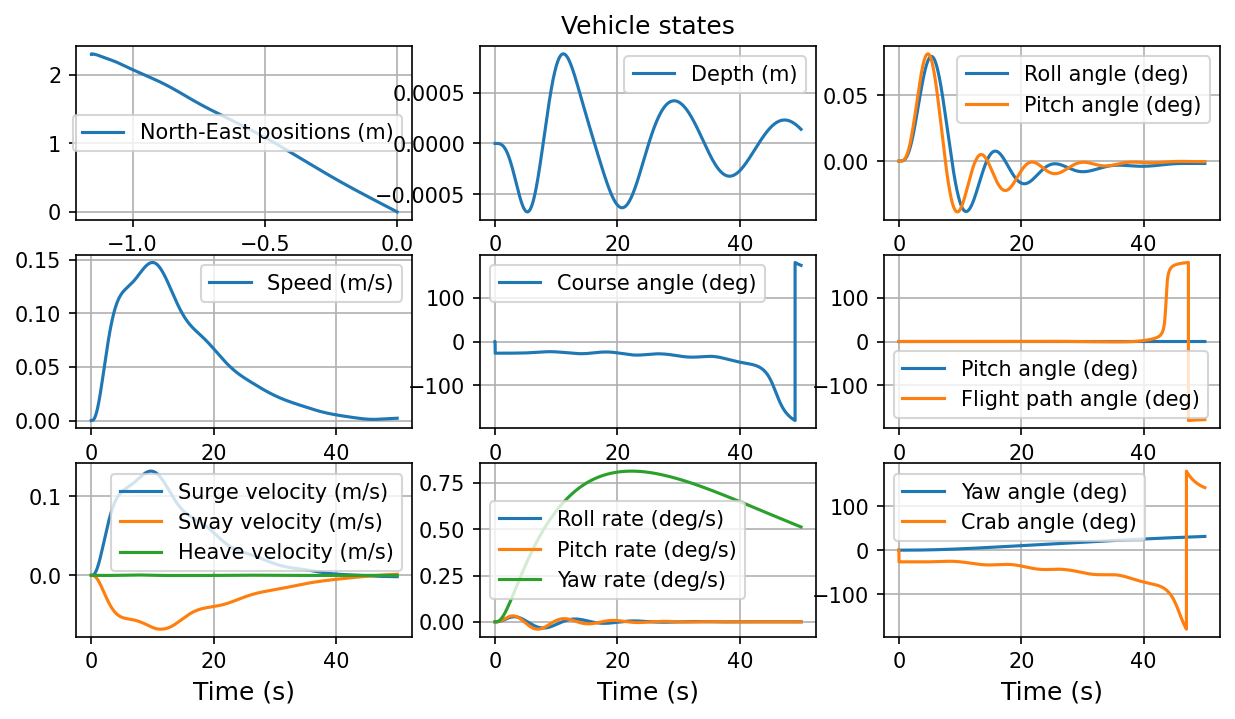

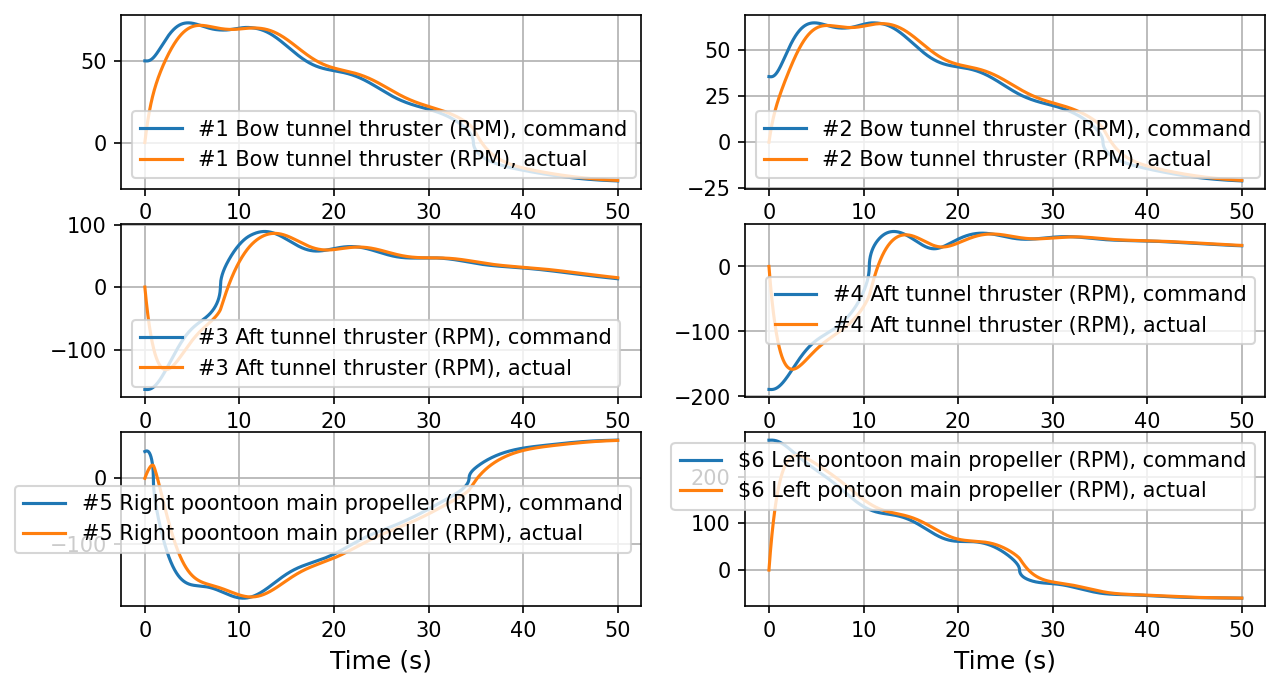

In [123]:
plotVehicleStates(simTime, simData, 1)
plotControls(simTime, simData, vehicle, 2)

In [124]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'

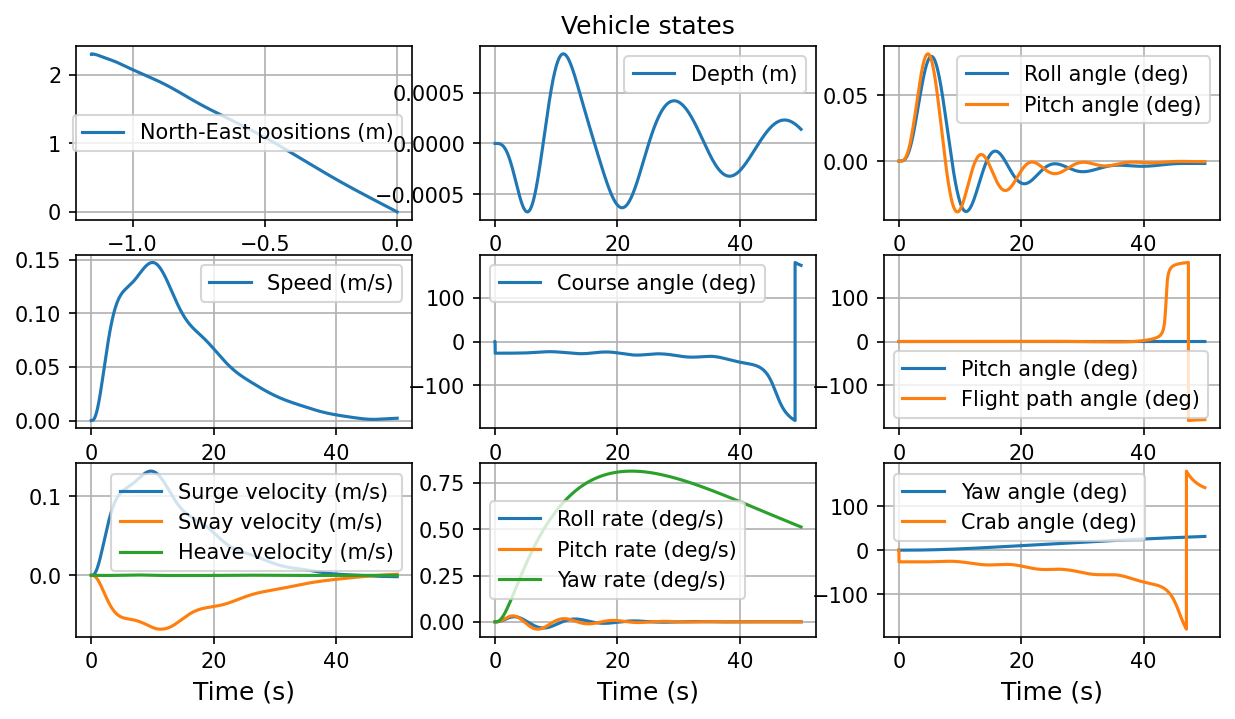

In [125]:
plotVehicleStates(simTime, simData, 3)

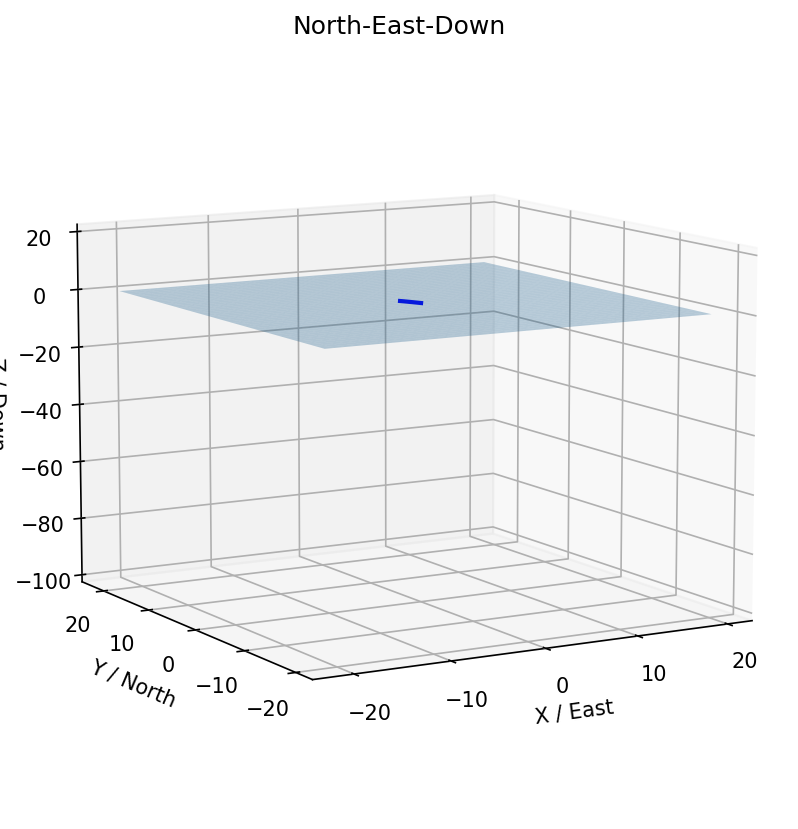

In [126]:
plot3D(simData, numDataPoints, FPS, filename, 3)

In [127]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [128]:
idx=1/0.01

In [129]:
idx

100.0

In [130]:
ssa(simData[:, 3][int(idx)])

4.347863402642815e-09

In [131]:
ssa(simData[:, 4][int(idx)])

5.966248384225992e-09

In [132]:
ssa(simData[:, 5][int(idx)])

1.3685324873335958e-08

In [133]:
def inert(M, m, X):
    sum_=M
    ans=[]
    for i in range(len(X)-1,-1,-1):
        sum_+=m
        ans.append(np.array(sum_).copy())

    return np.array(ans[::-1])

In [134]:
M_t=inert(vessel_mass*9.81,mp*9.81, x0)
Irho=inert(V_rho,Irho_ , x0)
# M_t=inert(0,mp*9.81, x0)
# Irho=inert(0,Irho_ , x0)

### Dynamics

In [135]:
class MyTime:
    def __init__(self):
        self.my_t = 0
        self.v_m = np.array([0,0,0,0,0,0]).astype(np.float64)
        self.progression = [i for i in range(100)]
        self.wall_clock = datetime.now()

In [136]:
def grayscott1d(t, Q, coefs, T):
#     print(t,T.my_t,t-T.my_t)
#     print(t)
#     if (t-T.my_t)!=0 and abs(t-T.my_t)<1e-10:
#         return 'error'

    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]

    idx = find_nearest(np.array(ans_t),  t)

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])




#     u_ve = simData[:, 6][idx]
#     v_ve = simData[:, 7][idx]
#     w_ve = simData[:, 8][idx]
#     p_ve = simData[:, 9][idx]
#     q_ve = simData[:, 10][idx]
#     r_ve = simData[:, 11][idx]


#     η=np.array([x_ve, y_ve, z_ve, phi_ve, theta_ve, psi_v])

#     dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])


#     n_ = myDPcontrol(vehicle,η,dη,sampleTime)
#     print(n_[2])


    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]


#     φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]

#     φ=ssa(φ)
#     θ=ssa(θ)
#     ψ=ssa(ψ)
#     Ret = Re_t(φ,θ,ψ)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]


    vessel_movement = np.zeros(6).astype(np.float64)
    vessel_movement[0] = x_ve - T.v_m[0]
    vessel_movement[1] = y_ve  - T.v_m[1]
    vessel_movement[2] = z_ve- T.v_m[2]
    vessel_movement[3] = phi_ve - T.v_m[3]
    vessel_movement[4] = theta_ve - T.v_m[4]
    vessel_movement[5] = psi_v - T.v_m[5]

    T.v_m[0] = x_ve
    T.v_m[1] = y_ve
    T.v_m[2] = z_ve
    T.v_m[3] = phi_ve
    T.v_m[4] = theta_ve
    T.v_m[5] = psi_v


#     else:
#         T.v_m[0] = 0.001
#         T.v_m[1] = 0
#         T.v_m[2] = 0
#         T.v_m[3] = 0
#         T.v_m[4] = 0
#         T.v_m[5] = 0

#     print(vessel_movement )
#     print(T.v_m,"l")


#     print(vessel_movement)
    fors, mom, angle = PipeForce(x, y, z, vessel_movement, coefs)
#     vessel_movement0=vessel_movement
#     print(fors.astype(np.float64))

    φ,θ,ψ=angle.T
    Ret = Re_t(φ,θ,ψ)

    Z0= - np.einsum('ijk,ik->ij', Re_b(Ret), fors).squeeze()
#     print(fors)

    Z1=d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T

    Z2=ne_(dx,dy,dz,DT,Ret).T


    Z= (
        Z1
        + Z2
        +Z0
       )

############################################################
    RRRR=Re_b(Ret)


    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',M_t,Re_b(Ret)),Z).T

    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################


    C1=np.einsum('ijk,ik->ij', Irho_e(Ret,Irho).astype(np.float64),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float64),
                                                                  np.array([dφ,dθ,dψ]).astype(np.float64).T))

    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)

    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret,Irho).astype(np.float64),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe(φ,θ,ψ,None,None,None))

    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None)).T, ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),None))

    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float64).T)

    C0=-np.einsum('ijk,ik->ij', np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)), mom ).squeeze()
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)

############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################
    T.my_t=t

    if t>T.progression[0]:
        T.progression.pop(0)
        print('Physical time: ', t, ' Iteration wall clock time: ', datetime.now() - T.wall_clock )
        T.wall_clock = datetime.now()

#     T.v_m=np.copy(vessel_movement)

    return np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)

In [137]:
tspan = (0., 25)
T_ = MyTime()

In [138]:
coefs = [1, 1, 1, 1, 1, 1]

In [139]:
startTime1 = datetime.now()
us=solve_ivp(grayscott1d,
             tspan,
             q0,
#             method='LSODA',
#              t_eval=[i*sampleTime/10 for i in range(int(tspan[-1]/(sampleTime/10)))],
#              atol=1e-2,
             args=(coefs,T_,))
print(datetime.now() - startTime1)

Physical time:  0.3462419251416382  Iteration wall clock time:  0:00:00.274701
Physical time:  1.0086432249077832  Iteration wall clock time:  0:00:15.986400
Physical time:  2.0069189111398833  Iteration wall clock time:  0:00:23.147374
Physical time:  3.0022698292196446  Iteration wall clock time:  0:00:22.821959
Physical time:  4.025514076689074  Iteration wall clock time:  0:00:19.209966
Physical time:  5.011376959475207  Iteration wall clock time:  0:00:15.968173
Physical time:  6.013038735646496  Iteration wall clock time:  0:00:13.343655
Physical time:  7.030201369021515  Iteration wall clock time:  0:00:11.390467
Physical time:  8.006290686659344  Iteration wall clock time:  0:00:10.158726
Physical time:  9.023418861779167  Iteration wall clock time:  0:00:10.255436
Physical time:  10.000092571333598  Iteration wall clock time:  0:01:01.480605
Physical time:  11.005512277983597  Iteration wall clock time:  0:00:22.674700
Physical time:  12.023120380494781  Iteration wall clock t

### Results

In [140]:
fin=us

In [141]:
fin

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  7.738e-02 ...  2.496e+01  2.500e+01]
        y: [[ 0.000e+00  1.095e-10 ...  1.495e+00  1.500e+00]
            [ 4.691e+01  4.691e+01 ...  4.843e+01  4.844e+01]
            ...
            [ 0.000e+00 -1.394e-13 ... -1.804e-08 -1.791e-08]
            [ 0.000e+00  3.435e-09 ...  7.345e-03  7.311e-03]]
      sol: None
 t_events: None
 y_events: None
     nfev: 4532
     njev: 0
      nlu: 0

In [142]:
t=fin.t

In [143]:
fin=fin.y.T

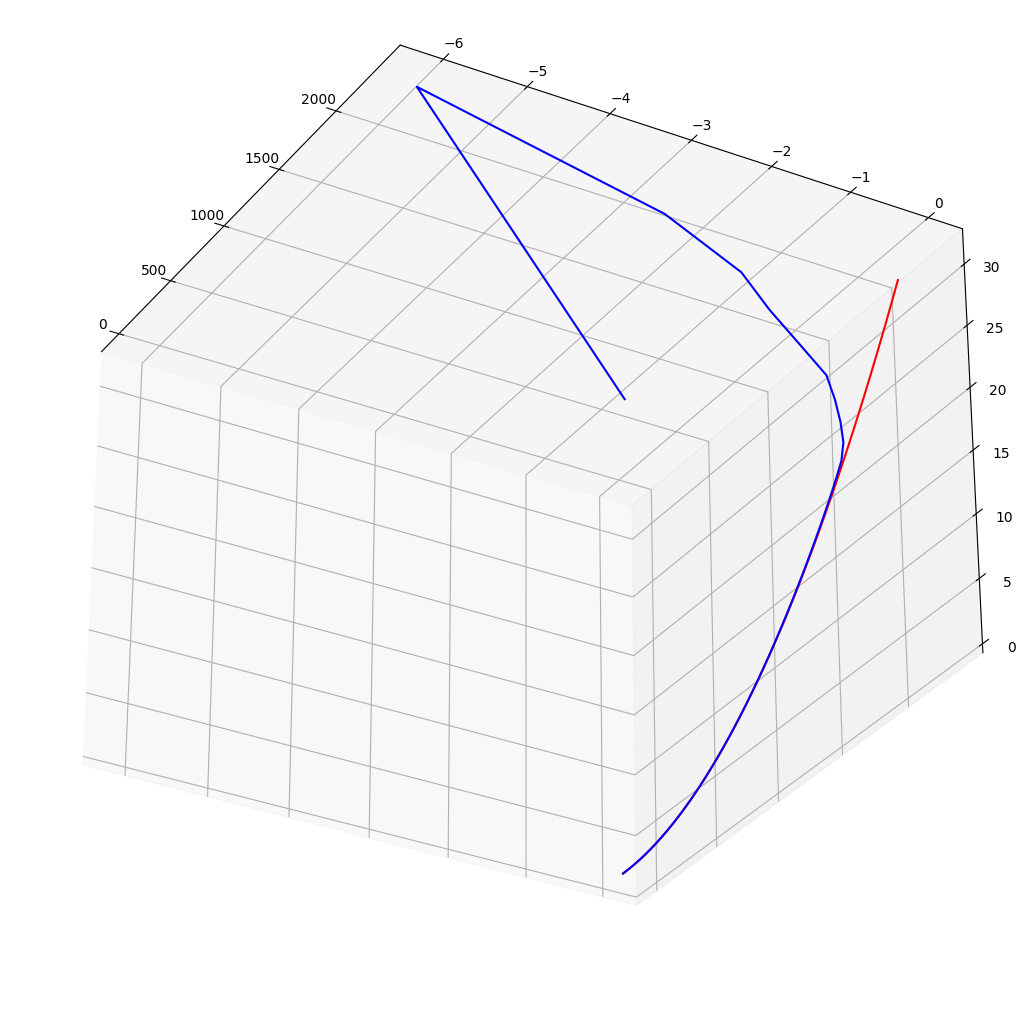

In [144]:
fig=plt.figure(figsize=(13,13))
ax = fig.add_subplot(projection = '3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)


ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b')
# ax.plot(x_fine, y_fine, z_fine, color='b')
ax.view_init(-45,-45)
ax.view_init(-30,-30)
# ax.view_init(0,-90)
plt.show()

In [145]:
X,Y,Z

(array([1.49951741e+00, 4.84370206e+01, 9.53759452e+01, 1.42316387e+02,
        1.89258450e+02, 2.36202248e+02, 2.83147906e+02, 3.30095563e+02,
        3.77045368e+02, 4.23997490e+02, 4.70952113e+02, 5.17909442e+02,
        5.64869706e+02, 6.11833159e+02, 6.58800087e+02, 7.05770811e+02,
        7.52745691e+02, 7.99725136e+02, 8.46709611e+02, 8.93699647e+02,
        9.40695851e+02, 9.87698924e+02, 1.03470968e+03, 1.08172906e+03,
        1.12875817e+03, 1.17579833e+03, 1.22285109e+03, 1.26991832e+03,
        1.31700228e+03, 1.36410575e+03, 1.41123216e+03, 1.45838581e+03,
        1.50557218e+03, 1.55279842e+03, 1.60007398e+03, 1.64741178e+03,
        1.69483009e+03, 1.74235610e+03, 1.79003355e+03, 1.83794439e+03,
        1.88635493e+03, 1.93588773e+03, 1.98670345e+03, 2.03911084e+03,
        2.09326231e+03, 2.14896920e+03, 2.20878715e+03, 2.27887513e+03,
        2.36976534e+03, 1.88413707e+03]),
 array([-4.37910954e-04, -4.57443289e-04, -4.78309072e-04, -5.00632675e-04,
        -5.2455334

In [146]:
X0,Y0,Z0

(array([   0.        ,   46.90501287,   93.81002573,  140.7150386 ,
         187.62005146,  234.52506433,  281.43007719,  328.33509006,
         375.24010292,  422.14511579,  469.05012866,  515.95514152,
         562.86015439,  609.76516725,  656.67018012,  703.57519298,
         750.48020585,  797.38521871,  844.29023158,  891.19524445,
         938.10025731,  985.00527018, 1031.91028304, 1078.81529591,
        1125.72030877, 1172.62532164, 1219.5303345 , 1266.43534737,
        1313.34036024, 1360.2453731 , 1407.15038597, 1454.05539883,
        1500.9604117 , 1547.86542456, 1594.77043743, 1641.67545029,
        1688.58046316, 1735.48547603, 1782.39048889, 1829.29550176,
        1876.20051462, 1923.10552749, 1970.01054035, 2016.91555322,
        2063.82056609, 2110.72557895, 2157.63059182, 2204.53560468,
        2251.44061755, 2298.34563041]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [147]:
us=fin.T

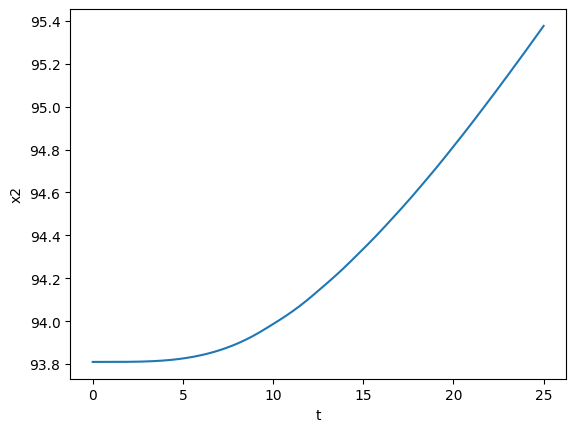

In [148]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

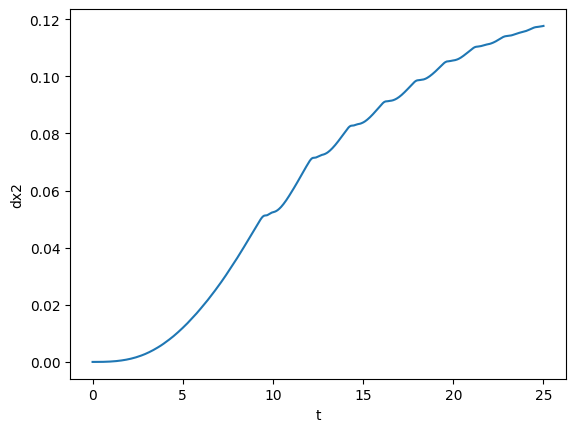

In [149]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

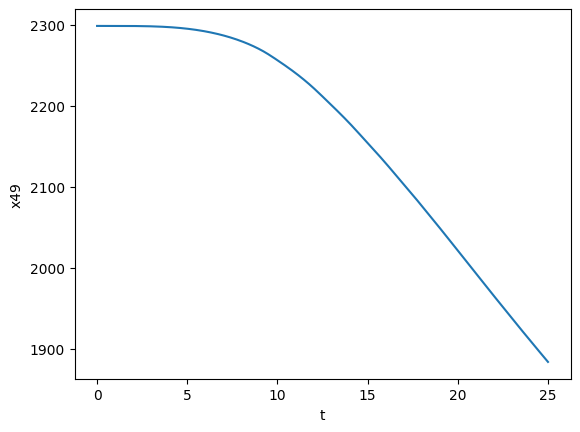

In [150]:
plt.plot(t,us.T[:,node_N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x49')
plt.show()

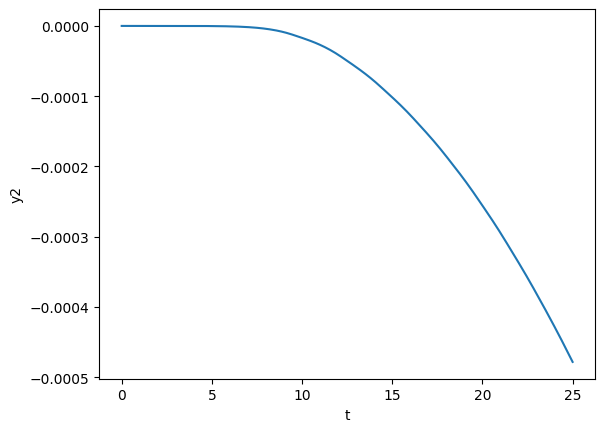

In [151]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

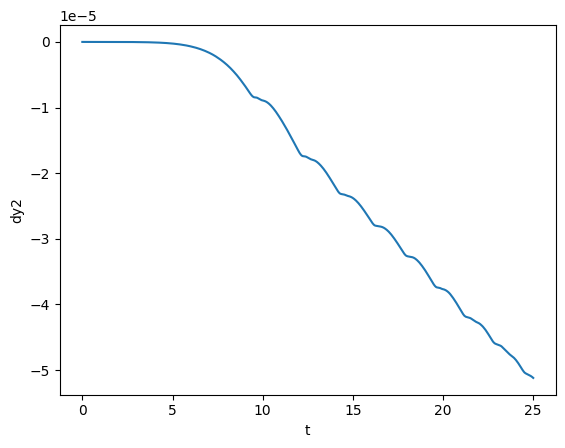

In [152]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

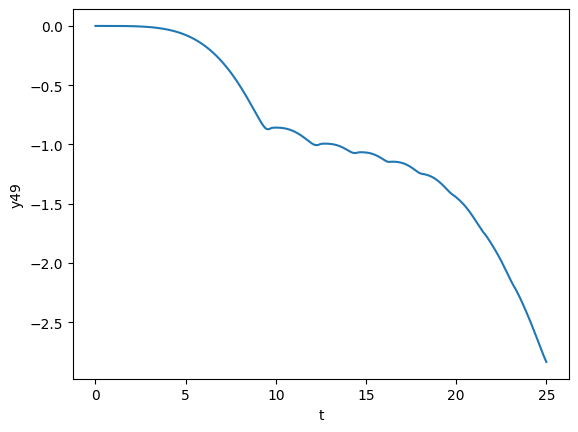

In [153]:
plt.plot(t,us.T[:,2*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('y49')
plt.show()

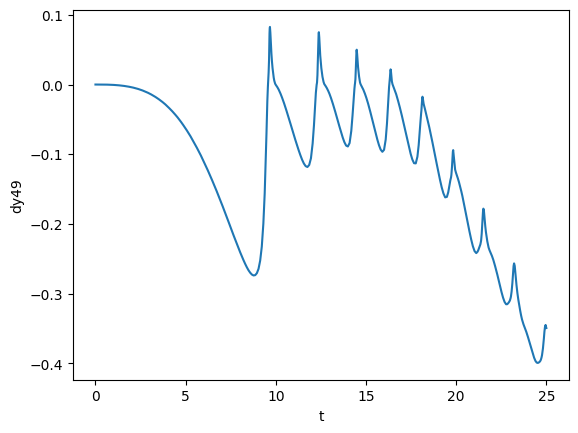

In [154]:
plt.plot(t,us.T[:,3*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('dy49')
plt.show()

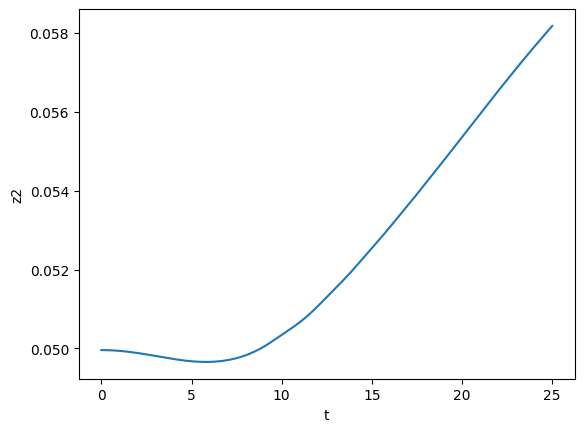

In [155]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

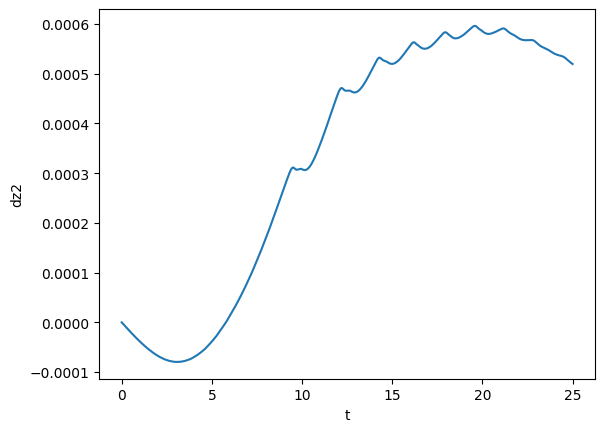

In [156]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

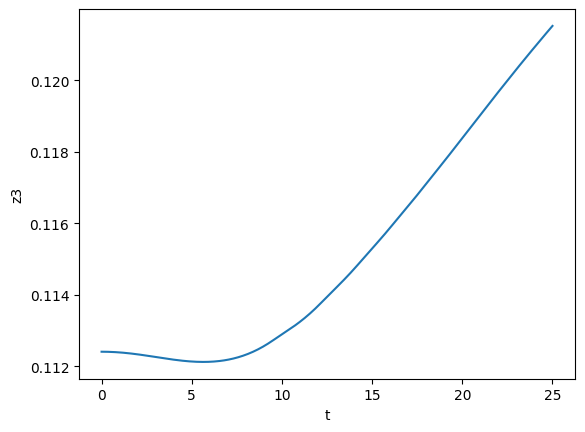

In [157]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

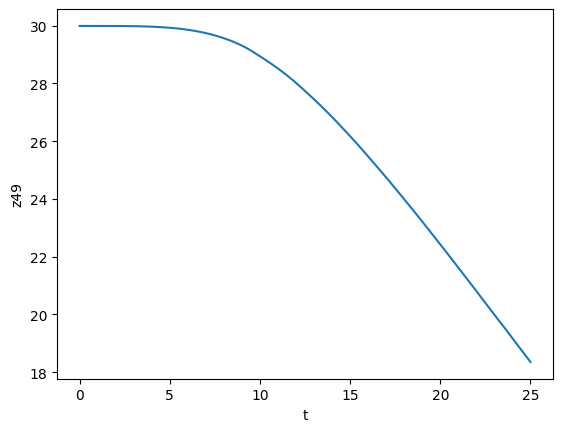

In [158]:
plt.plot(t,us.T[:,4*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('z49')
plt.show()

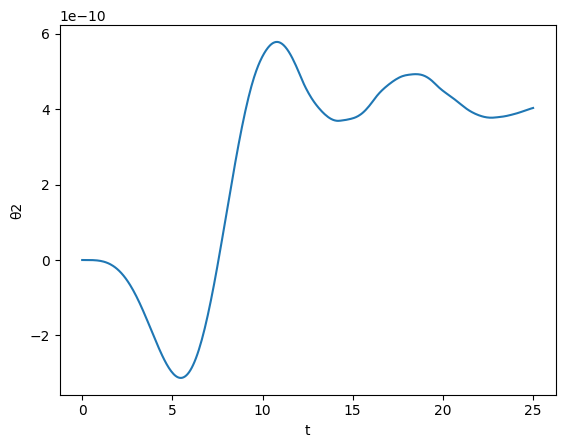

In [159]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

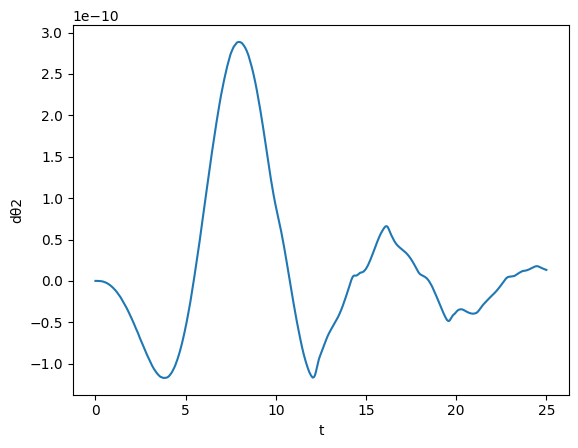

In [160]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

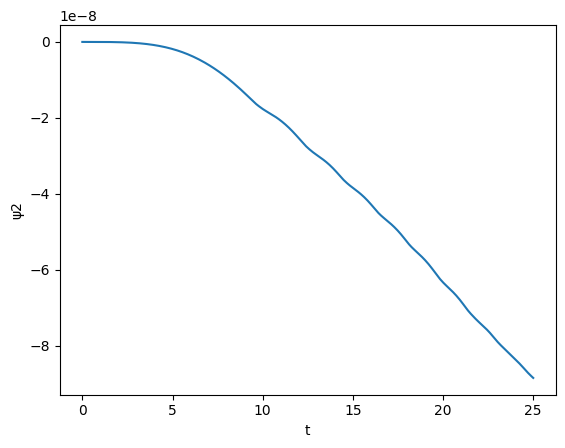

In [161]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

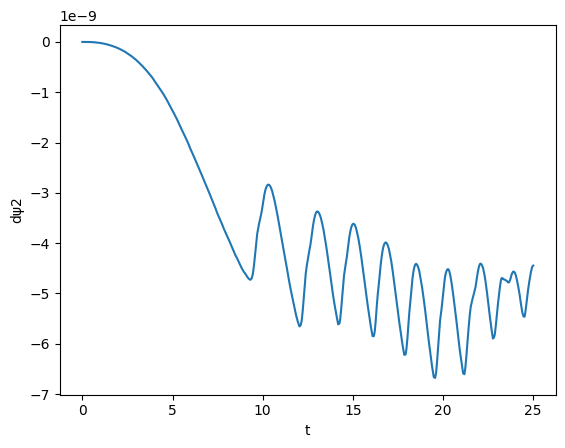

In [162]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()